# Метод k-ближайших соседей (kNN- k-Nearest Neighbor)

*Заполните этот блокнот, выполните код и защитите результаты. Полностью заполненный блокнот необходимо сохранить в электронном виде, передав его копию преподавателю, ведущему занятия. 

Классификация в соответствии с методом kNN состоит из двух этапов:

-     Во время обучения классификатор просто запоминает входные данные
-     Во время тестирования kNN-классификатор относит каждое тестовое изображение (сравнивая со всеми запомненными (обучающими) изображениями) к ближайшему из запомненных примеров обучения и выдает его метку
-     Значение k определяется в процессе кросс-валидации

Цель задания: реализовать указанные этапы,  изучить  базовую схему классификации изображений, кросс-валидации и сформировать навыки разработки эффективного векторизованного кода.

Этот блокнот является адаптированной версией аналогичного курса  [Стэнфордского университета](http://vision.stanford.edu/teaching/cs231n/index.html)

In [1]:
# Выполните некоторые установки для этого блокнота.
from __future__ import print_function

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt



# Это некоторая магия, чтобы изображения matplotlib отображались в блокноте,
# а не в новом окне.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # установка размера графика по умолчанию
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Еще немного магии, чтобы блокнот перезагружал внешние модули python;
# см. http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import sys
mem = sys.getsizeof('usedfor zipper fasten_coat')
value =  mem * 8000000  / 1024 / 1024

In [3]:
# Загрузка базы CIFAR-10.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Очистка переменных для предотвращения повторной загрузки данных (что может вызвать проблемы с памятью)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Для проверки работоспособности распечатаем размер данных обучения и тестирования.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


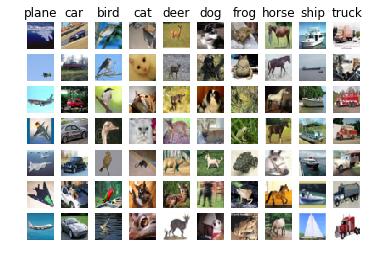

In [4]:
# Визуализируем некоторые изображения из набора данных.
# Показыважем несколько примеров изображений из каждого класса.

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Сделаем небольшую выборку из данных для более эффективного выполнения кода в этом задании
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [6]:
# Преобразуем матрицы изображений в векторы
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [7]:
from cs231n.classifiers import KNearestNeighbor

# Создадим экземпляр классификатора kNN.
# Напомним, что обучение классификатора kNN не выполняется:
# классификатор просто запоминает данные
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)


Теперь мы хотим  классифицировать тестовые данные с помощью классификатора kNN. Напомним, что этот процесс можно разбить на два этапа:

1. Сначала мы должны вычислить расстояния между каждым тестовым примером и всеми обучающими примерами.
2. С учетом этих расстояний для каждого тестового примера (изображения) необходимо найти k ближайших соседей (запомненных примеров) и выбрать метку, которая имеет наибольшее число голосов (чаще встречается).

Давайте начнем с вычисления матрицы расстояния между всеми обучающими и тестовыми примерами. Например, если есть **Ntr** обучающих (training) примеров и **Nte** тестовых (test) примеров, то мы должны получить матрицу, размером  **Nte x Ntr**, где каждый элемент (i,j) является расстоянием между i-м тестовым и  j-м обучающим примером.

Сначала откройте файл `cs231n/classifiers/k_nearest_neighbor.py` и реализуйте функцию `compute_distances_two_loops`, которая использует (весьма неэффективные) вложенные циклы по всем парам (тестовых и обучаемых) примеров и вычисляет матрицу расстояния по одному элементу за одну итерацию.

In [8]:
# Откройте cs231n/classifiers/k_nearest_neighbor.py  и реализуйте
# функцию compute_distances_two_loops.

# Протестируйте Вашу реализацию:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


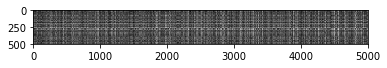

In [9]:
# Мы можем визуализировать матрицу расстояний: каждая строка соответствует одному тестовому изображению и
# его расстояниям до обучающих изображений
plt.imshow(dists, interpolation='none')
plt.show()

**Вопрос #1:** Обратите внимание на структуру видимых образов в матрице расстояний, в которой некоторые строки или столбцы видны ярче. (Обратите внимание, что при стандартной цветовой схеме по умолчанию черный цвет указывает на небольшие расстояния, а белый - на большие расстояния)

- Что в данных является причиной ярких строк?
- Что является причиной ярких столбцов?

**Ваш ответ**:
Каждое тестовое изображение будет иметь похожие метрики L2 до обучающих изображений
Каждое обучающее изображение имеет различное расстояние L2 до тестовых изображений



In [10]:
# Теперь реализуйте функцию predict_labels и выполните код ниже
# Мы используем k=1, что соответствует ближайшему соседу
y_test_pred = classifier.predict_labels(dists, k=1)

# Вычислите долю правильно предсказанных меток
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


Вы должны получить точность (accuracy) примерно `27%`. Теперь попробуйте использовать большие `k`, скажем `k = 5`:

In [11]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


Вы должны получить точность немного больше, чем при `k = 1`.

**Вопрос 2**: Мы можем также использовать и другие метрики расстояния, например L1.
Эффективность kNN-классификатора, использующего расстояние L1, не изменится, если
(выберите те ответы, которые верны):
1. Данные предварительно обрабатываются путем вычитания среднего значения.
2. Данные предварительно обрабатываются путем вычитания среднего значения и деления на стандартное отклонение.
3. Ось координат для данных вращается.
4. Ничего из перечисленного.

*Ваш выбор*:

*Ваше объяснение*:


In [12]:
# Теперь повысим скорость вычисления матрицы расстояний путем частичной векторизации
# одного цикла. Реализуйте функцию compute_distances_one_loop и выполните код ниже
dists_one = classifier.compute_distances_one_loop(X_test)

# Чтобы убедиться, что наша векторная реализация верна, мы должны проверить
# совпадение с предыдущей версией функции вычисления расстояний. 
# Существует много способов проверки аналогичности матриц; одной из самых простых
# является норма Фробениуса. Норма Фробениуса двух матриц - квадратный
# корень из суммы квадратов различий всех элементов; другими словами, необходимо
# преобразовать матрицы в векторы и вычислить евклидово расстояние между ними.

difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [13]:
# Теперь реализуйте полностью векторизованную версию функции 
# вычисления матрицы расстояний без циклов compute_distances_no_loops
# и выполните код ниже
dists_two = classifier.compute_distances_no_loops(X_test)

# проверьте, что матрица расстояний совпадает с ранее вычисленными матрицами
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [14]:
# Теперь сравним время выполнения 
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# Вы должны увидеть значительное сокращение времени для полностью векторизованного кода

Two loop version took 114.756604 seconds
One loop version took 178.299009 seconds
No loop version took 1.196990 seconds


### Кросс-валидация

Мы реализвали kNN-классификатор, но мы установили значение k = 5 произвольно. Теперь мы определим наилучшее значение этого гиперпараметра, используя кросс-валидацию.

In [15]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# ЗАДАНИЕ:                                                                     #
# Разделите обучающие данные на папки. После разделения "папки" X_train_folds  #
# и y_train_folds должны быть списками длины num_folds, где                    #
# y_train_folds[i] - это вектор меток для примеров из X_train_folds[i].        #
# Совет: используйте функцию numpy array_split.                                #
################################################################################
X_train_folds = np.array_split(X_train, num_folds, axis=0) # list
y_train_folds = np.array_split(y_train, num_folds, axis=0) # list
################################################################################
#                                 КОНЕЦ ВАШЕГО КОДА                            #
################################################################################

# Словарь, содержащий точности для разных значений k, которые мы находим
# при кросс-вылидации. После перекрестной проверки,
# k_to_accuracies[k] должен быть списком длины num_folds, содержащим разные
# значения точности, которые мы получили при соотвествующем k.
k_to_accuracies = {}


################################################################################
# ЗАДАНИЕ:                                                                     #
# Выполните кросс-валидацию, чтобы найти наилучшее значение k. Для каждого     #
# возможного значения k, запускайте алгоритм k-ближайшего соседа num_folds раз,#
# где в каждом случае вы используете для обучения все папки, кроме одной,      #
# которая используется как валидационная. Сохраняйте точность для всех папок и #
# всех значений k в словаре k_to_accuracies.                                   #
################################################################################
for i in range(num_folds):
    # train / validation split (80% 20%)
    X_train_batch = np.concatenate(X_train_folds[1:num_folds])   
    y_train_batch = np.concatenate(y_train_folds[1:num_folds])
    X_valid_batch = X_train_folds[0]   
    y_valid_batch = y_train_folds[0]

    # swap data (for next iteration)
    if i < num_folds - 1:
        tmp = X_train_folds[0]
        X_train_folds[0] = X_train_folds[i+1]
        X_train_folds[i+1] = tmp
        tmp = y_train_folds[0]
        y_train_folds[0] = y_train_folds[i+1]
        y_train_folds[i+1] = tmp

    
    # train model
    model = KNearestNeighbor()
    model.train(X_train_batch, y_train_batch)
    dists = model.compute_distances_no_loops(X_valid_batch)
    
    # compute accuracy for each k 
    for k in k_choices:
        y_valid_pred = model.predict_labels(dists, k=k)

        # compute validation accuracy
        num_correct = np.sum(y_valid_pred == y_valid_batch)
        accuracy = float(num_correct) / y_valid_batch.shape[0]

        # accumulate accuracy into dictionary
        if i == 0:
            k_to_accuracies[k] = [] 
        k_to_accuracies[k].append(accuracy)

################################################################################
#                                КОНЕЦ ВАШЕГО КОДА                             #
################################################################################

# Печать вычисленных точностей
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))


k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

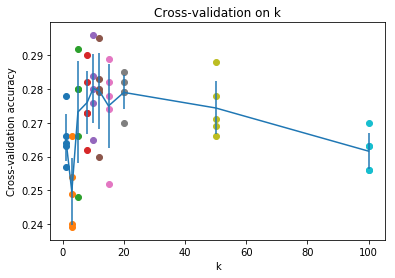

In [17]:
# отображение результатов наблюдений
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# построение линии тренда с диапазонами ошибок, которые соответствуют стандартным отклонениям
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [20]:
# Основываясь на результатах кросс-вылидации, выберите наилучшее значение  k,
# переобучите классификатор, используя все обучающие данные, проверьте его на тестовых
# данных. Вы должны быть получить точность более 28% на тестовых данных.

best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Вычисление и отображение точности
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


Какие из следующих утверждений относительно kNN классификатора верны?
Выбрать те ответы, которые подходят.
1. Ошибка обучения 1-NN классификатора всегда будет меньше, чем ошибка 5-NN классификатора.
2. Ошибка тестирования 1-NN классификатора всегда будет меньше, чем ошибка 5-NN классификатора.
3. Граница решения классификатора k-NN является линейной.
4. Время, необходимое для классификации тестового примера kNN-классификатором, растет с размером обучающего множества.
5. Ничего из вышеперечисленного.


*Ваш выбор*: 4

*Ваше объяснение*: 1, 2- зависит от данных
3 - граница сложная и часто не линейная.
4 - верно